# Interpretability in CNN s



In [1]:
import os
import copy
import numpy as np
from PIL import Image
import matplotlib.cm as mpl_color_map

import torch
from torch.autograd import Variable
from torchvision import models

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from misc_functions import *

In [4]:
img_path = 'imgs/cat_dog.png'
target_class = 243 ##  IMAGENET - cat_dog.png => 243

file_name_to_export = 'out.png'
original_image = Image.open(img_path).convert('RGB')
prep_img = preprocess_image(original_image)

# Layer by Layer visualization

In [5]:
import utils
vgg_model = models.vgg16(pretrained=True)
layers = list(vgg_model._modules['features']) + utils.toconv(list(vgg_model._modules['classifier']))
L = len(layers)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /home/ec2-user/.cache/torch/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:09<00:00, 57.4MB/s] 


In [6]:
layers

[Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 Conv2d(512, 512, kernel_size=(3, 3), stride=(1

In [7]:
from cnn_layer_visualization import *

In [8]:
cnn_layer = 17
filter_pos = 5

vgg_model = models.vgg16(pretrained=True)
vgg_features = vgg_model.features
layer_vis = CNNLayerVisualization(vgg_features, cnn_layer, filter_pos)

# Layer visualization with pytorch hooks
output_images = layer_vis.visualise_layer_with_hooks(max_iter=10)

In [9]:
layers_to_get = [(1,5), (5, 3), (15,0)]
layer_images = []
for cnn_layer,filter_pos in layers_to_get:
    layer_vis = CNNLayerVisualization(vgg_features, cnn_layer, filter_pos)
    output_images = layer_vis.visualise_layer_with_hooks(max_iter=20)
    layer_images.append(output_images[-1])

Iteration: 10 Loss: -1.29
Iteration: 10 Loss: -10.27
Iteration: 10 Loss: -77.31


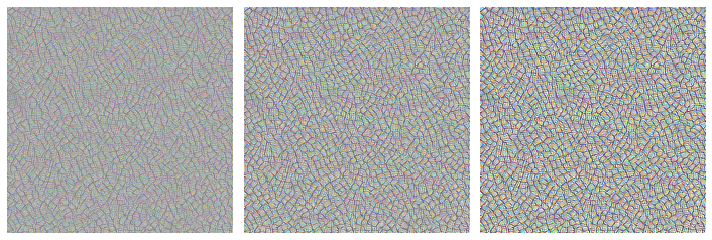

In [16]:
count = 1
nrows = 1
ncols = len(layer_images)
fig = plt.figure(figsize=(10, 10))
for i in range(nrows):
    for j in range(ncols):
        ax1 = fig.add_subplot(nrows, ncols, count)
        ax1.imshow(output_images[j])
        ax1.axis('off')
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
        count +=1
plt.tight_layout()
plt.show()

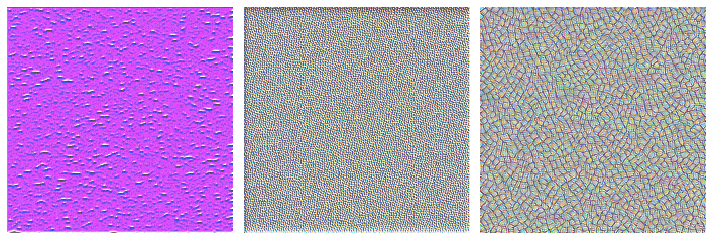

In [17]:
count = 1
nrows = 1
ncols = len(layer_images)
fig = plt.figure(figsize=(10, 10))
for i in range(nrows):
    for j in range(ncols):
        ax1 = fig.add_subplot(nrows, ncols, count)
        ax1.imshow(layer_images[j])
        ax1.axis('off')
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
        count +=1
plt.tight_layout()
plt.show()

## Gradient Based Explanation

A gradient-based explanation method tries to explain a given prediction by using the gradient of (i.e. change in) the output with respect to the input features. Some methods like Integrated Gradients (IG), GradCAM, and SmoothGrad literally apply the gradient operator. Other methods like DeepLift and LRP apply “discrete gradients.”

### Saliency Maps

The purpose of the saliency map approach is to query an already-trained classification CNN about the spatial support of a particular class in a particular image, i.e., “figure out where the dog is in the dog photo without any explicit location labels.”

## Vanilla Backpropagation Saliency

Vanilla Backpropagation: apply model to image, set class of interest, backprop to compute gradient with respect to specified class.

extension: DeepLift : https://arxiv.org/pdf/1704.02685v1.pdf

Guided Backpropagation: apply model to image, set class of interest, backprop to compute gradient with respect to specified class. Except that this time during the backpropagation process, replace all gradients which are less than 0 with 0

In [11]:
from vanilla_backprop import *

In [12]:
vgg_model = models.vgg16(pretrained=True)

(3, 224, 224)


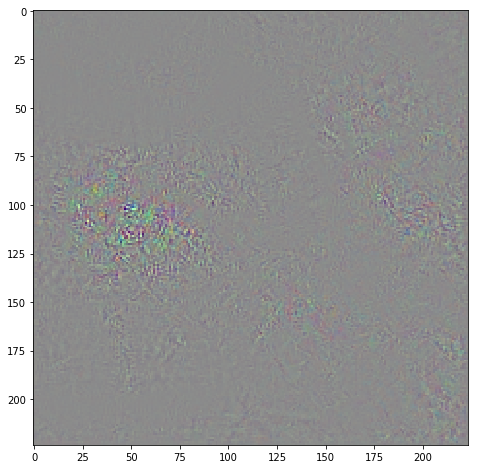

In [20]:
VBP = VanillaBackprop(vgg_model)

# Generate gradients
vanilla_grads = VBP.generate_gradients(prep_img, target_class)

# Convert to grayscale
grayscale_vanilla_grads = convert_to_grayscale(vanilla_grads)

# Normalize
gradient = vanilla_grads - vanilla_grads.min()
gradient /= gradient.max()
out_img = np.swapaxes(gradient, 0, 2)

print (gradient.shape)
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(out_img)

In the above image you sort of get an idea of which pixels are sensitive to gradient changes, but you doesn't give you any meaningful insights

## Layerwise Relevance Propogation
https://heatmapping.org

Activations in the top layer are the scores the neural network predicts for each class.
We show below the 10 classes with highest score:


In [21]:
X = prep_img

In [32]:
import matplotlib.image as mpimg

TypeError: Invalid dimensions for image data

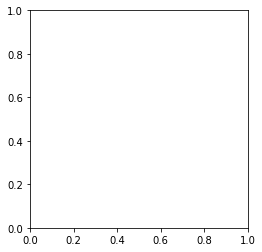

In [31]:
plt.imshow(prep_img.squeeze().detach())

In [15]:
A = [X]+[None]*L
for l in range(L): A[l+1] = layers[l].forward(A[l])

scores = np.array(A[-1].data.view(-1))
ind = np.argsort(-scores)
for i in ind[:10]:
    print('%20s (%3d): %6.3f'%(utils.imgclasses[i][:20],i,scores[i]))

        bull mastiff (243): 12.565
        pug, pug-dog (254): 11.559
            radiator (753):  9.602
               boxer (242):  9.495
washer, automatic wa (897):  8.570
dishwasher, dish was (534):  8.521
American Staffordshi (180):  8.222
        sliding door (799):  8.221
doormat, welcome mat (539):  8.212
tiger, Panthera tigr (292):  8.134


In [16]:
T = torch.FloatTensor((1.0*(np.arange(1000)==483).reshape([1,1000,1,1])))
R = [None]*L + [(A[-1]*T).data]
for l in range(1,L)[::-1]:
    
    A[l] = (A[l].data).requires_grad_(True)

    if isinstance(layers[l],torch.nn.MaxPool2d): layers[l] = torch.nn.AvgPool2d(2)

    if isinstance(layers[l],torch.nn.Conv2d) or isinstance(layers[l],torch.nn.AvgPool2d):

        if l <= 16:       rho = lambda p: p + 0.25*p.clamp(min=0); incr = lambda z: z+1e-9
        if 17 <= l <= 30: rho = lambda p: p;                       incr = lambda z: z+1e-9+0.25*((z**2).mean()**.5).data
        if l >= 31:       rho = lambda p: p;                       incr = lambda z: z+1e-9

        z = incr(utils.newlayer(layers[l],rho).forward(A[l]))  # step 1
        s = (R[l+1]/z).data                                    # step 2
        (z*s).sum().backward(); c = A[l].grad                  # step 3
        R[l] = (A[l]*c).data                                   # step 4
        
    else:
        
        R[l] = R[l+1]

* Optional Reading: Explaining the prediction with LRP


The following code iterates from the top layer to the first layer in reverse order and applies propagation rules at each layer. Top-layer activations are first multiplied by the mask to retain only the predicted evidence for the class "bull mastiff".

T = torch.FloatTensor((1.0*(numpy.arange(1000)==483).reshape([1,1000,1,1])))

R = [None]*L + [(A[-1]*T).data]
This evidence can then be propagated backward in the network by applying propagation rules at each layer.

Convolution layers: Observing that convolutions are special types of linear layers, we can use the same propagation rules as in the MNIST example, and a similar four-step procedure for applying these rules. Steps 2 and 4 are simple element-wise computations. Step 1 can be implemented as a forward computation in the layer, where we have preliminary transformed the layer parameters, and where we apply the increment function afterwards. As shown in the LRP overview paper, Step 3 can instead be computed as a gradient in the space of input activations:

cj=[∇ (∑k zk(a)⋅sk)]j
 

where  sk  is treated as constant.

Pooling layers: It is suggested in Section 10.3.2 of the paper to treat max-pooling layers as average pooling layers in the backward pass. Observing that average pooling is also a special linear layer, the same propagation rules as for the convolutional layers become applicable.

In the following code, we iterate the propagation procedure from the top-layer towards the lower layers. Whenever we meet a max-pooling layer, we convert it into an average pooling layer. The function rho and incr are set differently at each layer, following the strategy of Section 10.3.

In [17]:
## LRP Visualization

As each layer is composed of a collection of two-dimensional feature maps, relevance scores at each layer can be visualized as a two-dimensional map. Here, relevance scores are pooled over all feature maps at a given layer. The two-dimensional maps are shown for a selection of VGG-16 layers.

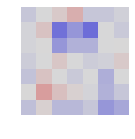

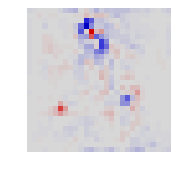

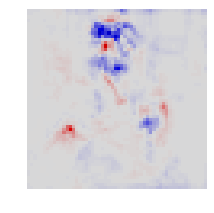

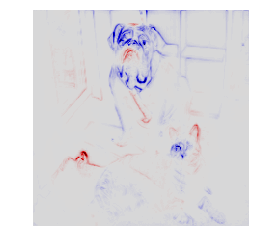

In [18]:
layers_to_viz = [31,21,11,1]
for i,l in enumerate(layers_to_viz):
    utils.heatmap(np.array(R[l][0]).sum(axis=0),0.5*i+1.5,0.5*i+1.5)

We observe that the explanation becomes increasingly resolved spatially. We have stopped the propagation procedure one layer before the pixels because the rule we have used is not applicable to pixel layers. 

We needn ot apply the pixel-specific  z -rule for this last layer. This rule can again be implemented in terms of forward passes and gradient computations.

In [19]:
A[0] = (A[0].data).requires_grad_(True)

lb = (A[0].data*0+(0)).requires_grad_(True)
hb = (A[0].data*0+(1)).requires_grad_(True)

z = layers[0].forward(A[0]) + 1e-9                                     # step 1 (a)
z -= utils.newlayer(layers[0],lambda p: p.clamp(min=0)).forward(lb)    # step 1 (b)
z -= utils.newlayer(layers[0],lambda p: p.clamp(max=0)).forward(hb)    # step 1 (c)
s = (R[1]/z).data                                                      # step 2
(z*s).sum().backward(); c,cp,cm = A[0].grad,lb.grad,hb.grad            # step 3
R[0] = (A[0]*c+lb*cp+hb*cm).data                                       # step 4

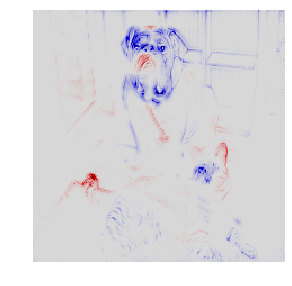

In [20]:
utils.heatmap(np.array(R[0][0]).sum(axis=0),3.5,3.5)

We observe that the heatmap highlights the outline of the castle as evidence for the corresponding class. Blue highlights negative effect and red positive importance

## GRADCAM


In [21]:
!pip install opencv-python

fastai 1.0.59 requires nvidia-ml-py3, which is not installed.
You are using pip version 10.0.1, however version 20.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [25]:
from gradcam import *
import cv2

target_layer_id = 20 # Find the layer to visualize the relevant CAM# 
pretrained_model = models.vgg16(pretrained=True)

grad_cam = GradCam(pretrained_model, target_layer=target_layer_id)
cam = grad_cam.generate_cam(prep_img, target_class)

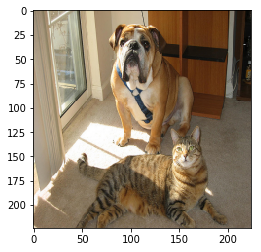

In [26]:
plt.imshow(original_image)

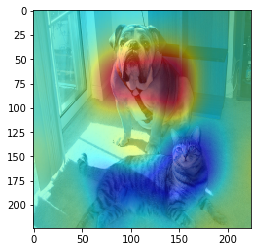

In [27]:
## overlay the heatmap on original image
np_image = np.array(original_image)
outcam = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET) # grayscale to color
outcam = np.float32(outcam) + np.float32(np_image) # overlay heatmap
outcam = 255 * outcam / (np.max(outcam) + 1E-5) ##  Add expsilon for stability
outcam = np.uint8(outcam)[:, :, ::-1] # to RGB
plt.imshow(outcam)

## LRP vs GRADCAM

In LRP, each neuron of the network receives a share of the model output and gets redistributed to its predecessors until the input variables are reached. 

GradCAM captures higher-level visual concepts and is able to attribute the parts of input to individual classes. 

## Exersice 

In [ ]:
# 1. TODO: Find the right layer to visualize GradCAM for VGG16
# hint: inspect the layers

In [ ]:
#2. Try generating similar heatmap for alexnet 
#pretrained_model = models.alexnet(pretrained=True)

In [ ]:
#3. Generate heatmaps for other images. Don't forget to change the imagenet class ID

# SHAP for CNNs/ Images

In [ ]:
!pip install shap

In [ ]:
import shap

In [ ]:
img_arr = np.array(original_image)

In [ ]:
X_input = np.expand_dims(img_arr, axis=0)
X_input = np.swapaxes(X_input, 1, 3)
X_input.shape

In [ ]:
X_tensor = torch.Tensor(X_input)

In [ ]:
vgg_model = models.vgg16(pretrained=True)

In [ ]:
e = shap.GradientExplainer(vgg_model, X_tensor)

In [ ]:
e = shap.DeepExplainer(vgg_model, X_tensor)

In [ ]:
# This takes time so we'll skip for now, but execute later
#shap_values = e.shap_values(X_tensor)

In [ ]:
# rehspae the shap value array and test image array for visualization 

#shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
#test_numpy = np.swapaxes(np.swapaxes(test_images.numpy(), 1, -1), 1, 2)


# plot the feature attributions
#shap.image_plot(shap_numpy, -test_numpy)

In [ ]:
Notes: http://www.andrewjanowczyk.com/visualizing-densenet-using-pytorch/
       https://h1ros.github.io/posts/explain-image-classification-by-shap-deep-explainer/